In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

  Activating environment at `~/FiB/reco_code/NReco/Project.toml`


In [2]:
using ATools
using NReco
using Configurations
using DataFrames
using Distributions
using Glob
using HDF5
using Logging
using Plots
using Statistics
using StatsBase
using Unitful
using Printf
using CSV
import Unitful: ps, mm, cm

In [3]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n4-40mm.toml"
conf        = from_toml(NReco.CalConfig, config_file)

NReco.CalConfig("../../h5data/", "n4-dz1m-LXe40mm-noQrz-4/", "plot_dir", 1700.0f0, 2200.0f0, false, NReco.CalFunction("../config/radius_calibration.h5", "n3-40mm", "cstd", 1.69f0))

In [4]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n4-dz1m-LXe40mm-noQrz-4/"

In [5]:
in_path

"../../h5data/n4-dz1m-LXe40mm-noQrz-4/"

In [6]:
norm, rmin, rmax, ndf = read_evtpar(glob("evt*.h5", in_path))
println(norm, " simulated events, ", nrow(ndf), " with two interactions: ", 100 * nrow(ndf) / norm, "%")

30000000 simulated events, 8097986 with two interactions: 26.993286666666666%


# Check on total charge

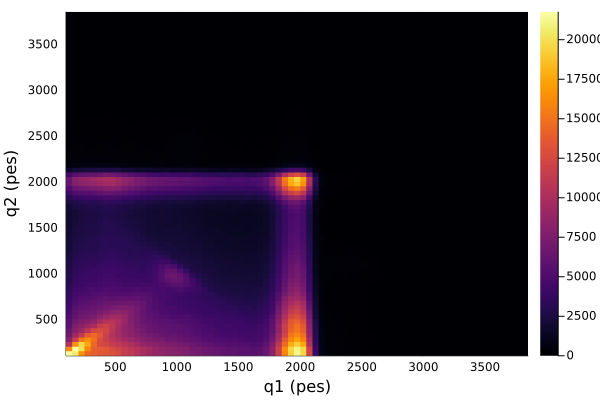

In [7]:
q1min, q1max = (minimum(ndf.q1), maximum(ndf.q1))
q2min, q2max = (minimum(ndf.q2), maximum(ndf.q2))
_, pq1q2 = hist2d(ndf.q1, ndf.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2)

In [8]:
ndfq = NReco.filter_energies(ndf, conf.qmin, conf.qmax)
println("Photoelectric charge cut leaves ", nrow(ndfq) / nrow(ndf), " of the double interactions, ", nrow(ndfq) / norm, "% of simulated events.")

Photoelectric charge cut leaves 0.07297481126788809 of the double interactions, 0.0196983% of simulated events.


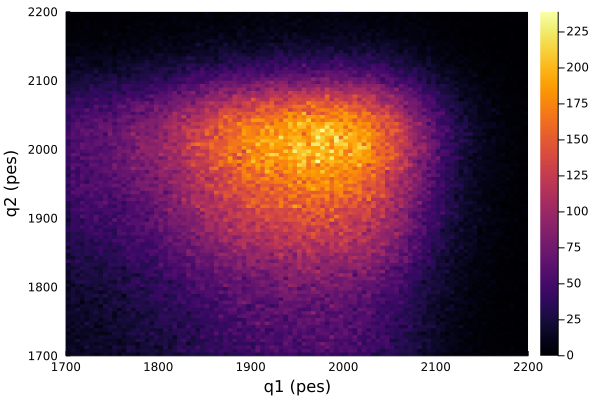

In [9]:
_, pq1q2_f = hist2d(ndfq.q1, ndfq.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2_f)

# Combine the two hemispheres for calibration

## Correlations between the size of the area of charge seen and the interaction radius

## Combination slightly better predictor, use it in this version

# For now we're going to save the calibration constants and calculate and save LOR info here. This should be formalised better.

## NEMA 4

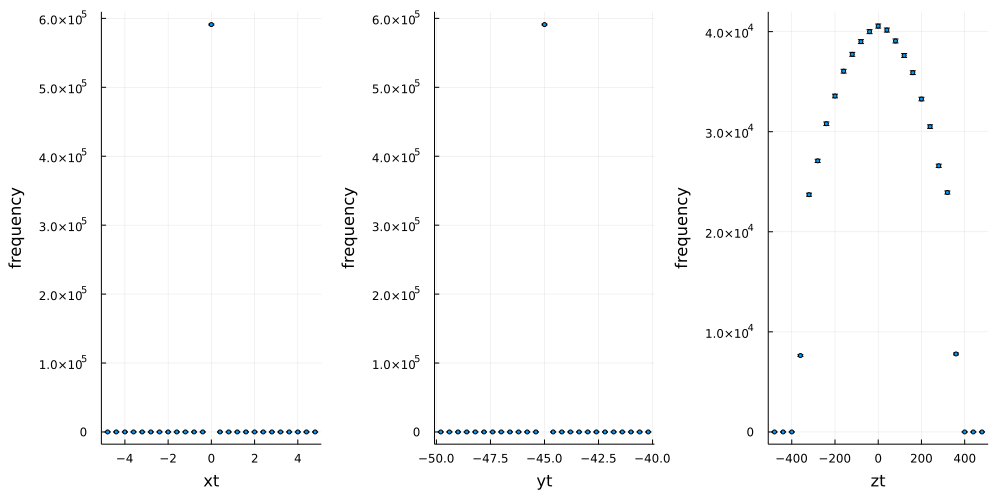

In [10]:
hx,px = hist1d(ndfq.xs, "xt", 25, -5.0f0, 5.0f0, norm=false)
hz,pz = hist1d(ndfq.zs, "zt", 25, -500.0f0, 500.0f0, norm=false)
hy,py = hist1d(ndfq.ys, "yt", 25, -50.0f0, -40.0f0, norm=false)
plot(px,py,pz, layout= (1, 3), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

### Read lors

In [11]:
lor_path = joinpath(in_path, string(split(in_path,"/")[end-1],"_mlor.h5")) 

"../../h5data/n4-dz1m-LXe40mm-noQrz-4/n4-dz1m-LXe40mm-noQrz-4_mlor.h5"

In [12]:
lors_average_recall = readh5_todf(lor_path, "reco_info", "lors");

In [13]:
first(lors_average_recall,5) 

,dx,x1,y1,z1,x2,y2,z2
,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,287.695,-329.556,-175.528,-413.843,351.926,89.3571,-182.994
2,-214.385,129.808,343.492,157.85,-100.135,-344.574,55.9716
3,350.451,-80.8727,-345.725,-81.1286,118.304,354.542,-55.6843
4,-283.929,-213.455,284.842,-397.042,175.413,-317.0,405.518
5,111.822,-50.9874,-353.005,49.1368,71.5171,381.405,228.248


In [14]:
function distance_lor_to_point(x1::Real,y1::Real,x2::Real,y2::Real,
                               x0::Real=0.0,y0::Real=0.0)
  num = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
  den = sqrt((x2 -x1)^2 + (y2 - y1)^2)
  Float32(num/den)
end

distance_lor_to_point (generic function with 3 methods)

In [15]:
function sinogramdf(ldf)
  # add z, θ and r columns
  ldf[!, "zl"] = ldf.z1 - ldf.z2;
  ldf[!, "rl"] = distance_lor_to_point.(ldf.x1, ldf.y1, ldf.x2, ldf.y2, 
                                      zeros(nrow(ldf)), zeros(nrow(ldf)))
  ldf[!, "tl"] = atan.(ldf.x1, ldf.y1)
  return ldf
end   

sinogramdf (generic function with 1 method)

In [16]:
function xsgrm(df::DataFrame, sgrm="tl"; ntproj::Integer, nbinr=20, rmin=0.0f0, rmax=75.0f0, zmin=-350.0f0, zmax=350.0f0)
  if sgrm == "tl"
    ht  = hist1d(df.tl, ntproj, -Float32(π), Float32(π))
  else
    ht  = hist1d(df.zl, ntproj, zmin, zmax)
  end
  hte = edges(ht)
  RT = [select_by_column_value_interval(df, sgrm, hte[i], hte[i+1]) for i in 1:length(hte)-1]
  [hist1d(dfx.rl, nbinr, rmin, rmax) for dfx in RT]
end



xsgrm (generic function with 2 methods)

In [17]:
function stp(hrl::Histogram; i0::Integer = 5, i1::Integer = 15)
    w = Float64.(hrl.weights)
    e = edges(hrl)[1:end-1]
    w0 = w[i0]                        # contents of bin
    w1 = w[i1]
    im, _, wm = find_max_xy(e, w)
    spb = w[i0:i1]
    fxy = gline2p(i0, w0, i1, w1)
    bkg = [fxy(i) for i in i0:i1]
    sgn = spb - bkg
    sgn = [s > 0 ? ceil(s) : 0.0 for s in sgn]
    T = sum(sgn)
    P = sum(w)
    S = P - T

    return S, T, P
end

stp (generic function with 1 method)

In [18]:
sxdf = sinogramdf(lors_average_recall)
first(sxdf,5)

,dx,x1,y1,z1,x2,y2,z2,zl
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,287.695,-329.556,-175.528,-413.843,351.926,89.3571,-182.994,-230.848
2,-214.385,129.808,343.492,157.85,-100.135,-344.574,55.9716,101.879
3,350.451,-80.8727,-345.725,-81.1286,118.304,354.542,-55.6843,-25.4443
4,-283.929,-213.455,284.842,-397.042,175.413,-317.0,405.518,-802.559
5,111.822,-50.9874,-353.005,49.1368,71.5171,381.405,228.248,-179.111


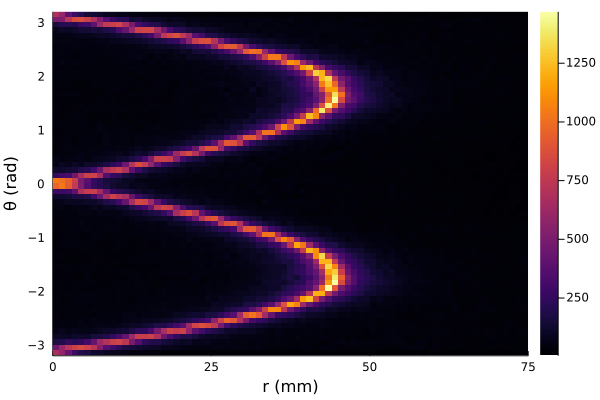

In [19]:
h1,p1 = hist2d(sxdf.rl, sxdf.tl, 100, "r (mm)", "θ (rad)",
               0.0f0, 75.0f0, -Float32(π), Float32(π))
plot(p1, fmt = :png)

In [20]:
rhst =xsgrm(sxdf, "tl", ntproj=4, nbinr=20, rmin=0.0f0, rmax=60.0f0);

In [21]:
PLT=[]
for (i, hst) in enumerate(rhst)
    lbl = string("θ-bin =", string(i))
    _, p = hist1d(hst, lbl)
    push!(PLT,p)
end

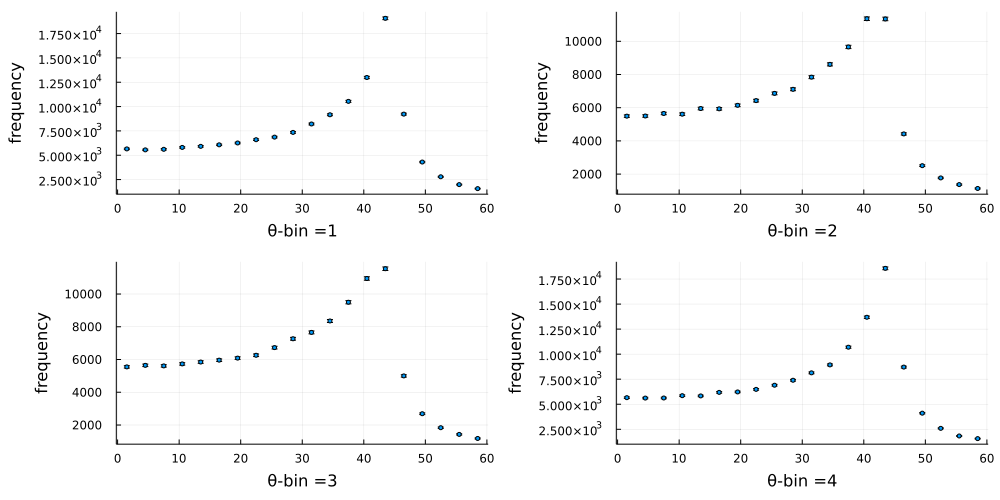

In [22]:
pThetaBin = plot(PLT..., layout= (2, 2), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [23]:
png(pThetaBin, "LOR_thetabin_40mm")

In [24]:
SOT = []
for (i, hrl) in enumerate(rhst)
    println("θ bin =", i)
    S, T, P = stp(hrl, i0 = 7, i1 = 20)
    push!(SOT, S/T)
    @printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
    
end
@printf "\nS/T (average) = %5.1f" mean(SOT)

θ bin =1
 T = 52085.0 S = 89406.0 P = 141491.0 S/T =   1.7θ bin =2
 T = 35899.0 S = 84796.0 P = 120695.0 S/T =   2.4θ bin =3
 T = 35843.0 S = 84954.0 P = 120797.0 S/T =   2.4θ bin =4
 T = 51359.0 S = 89227.0 P = 140586.0 S/T =   1.7
S/T (average) =   2.0

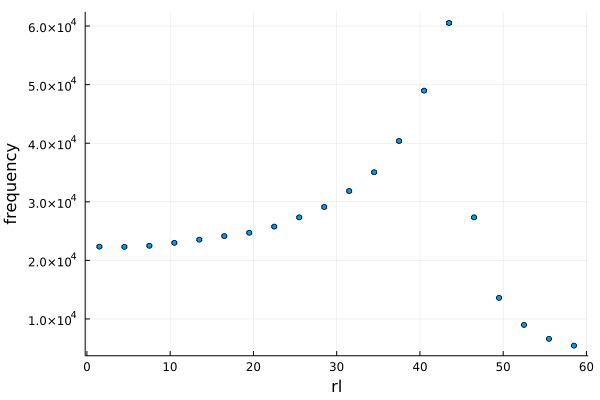

In [25]:
hr,pr = hist1d(sxdf.rl, "rl", 20, 0.0f0, 60.f0)
plot(pr)

In [26]:
png(pr, "rPosAllLOR")

In [27]:
zhst =xsgrm(sxdf, "zl", ntproj=4, nbinr=20, rmin=0.0f0, rmax=60.0f0);

In [28]:
PRZ=[]
for (i, hst) in enumerate(zhst)
    lbl = string("z-bin =", string(i))
    _, p = hist1d(hst, lbl)
    push!(PRZ,p)
end

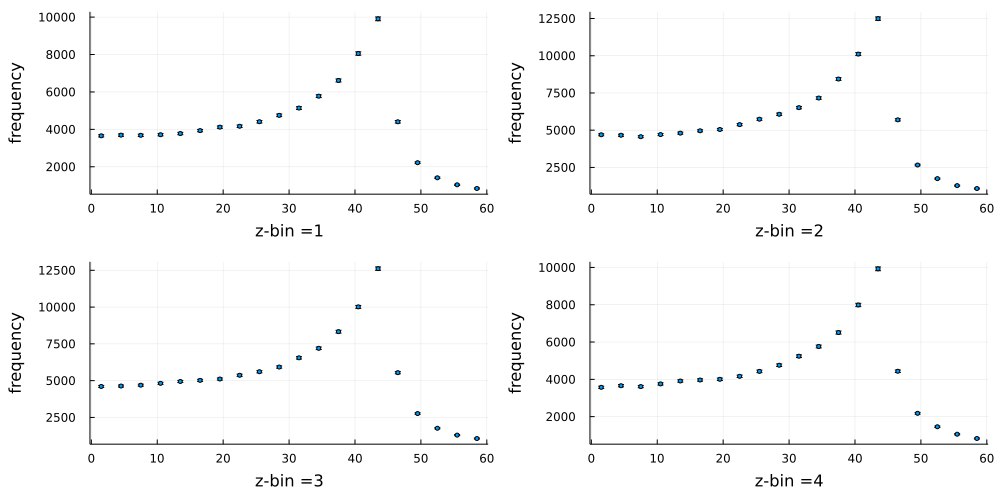

In [29]:
pZbin = plot(PRZ..., layout= (2, 2), legend=false, fmt = :png, size = (1000, 500),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [30]:
png(pZbin, "LOR_zabin_40mm")

In [31]:
SOTZ = []
for (i, hrl) in enumerate(zhst)
    println("z bin =", i)
    S,T,P = stp(hrl, i0 = 7, i1 = 20)
    push!(SOTZ, S/T)
    @printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
end
sot = mean(SOTZ)
@printf "\nS/T (average) = %5.1f" sot

z bin =1
 T = 28188.0 S = 57114.0 P = 85302.0 S/T =   2.0z bin =2
 T = 36611.0 S = 71175.0 P = 107786.0 S/T =   1.9z bin =3
 T = 36002.0 S = 71845.0 P = 107847.0 S/T =   2.0z bin =4
 T = 28931.0 S = 56268.0 P = 85199.0 S/T =   1.9
S/T (average) =   2.0

In [32]:
S,T,P = stp(hr, i0 = 7, i1 = 20)
@printf " T = %5.1f S = %5.1f P = %5.1f S/T = %5.1f" T S P S/T
println()
nec = T/(1 + S/T)   
@printf " nec = %5.1f, SNR = %5.1f NEC/P = %5.2f " nec sqrt(nec) nec/P

 T = 174879.0 S = 348690.0 P = 523569.0 S/T =   2.0
 nec = 58411.9, SNR = 241.7 NEC/P =  0.11 

### NEC curves

In [33]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n4-40mm-singles.toml"
conf        = from_toml(NReco.CalConfig, config_file)

NReco.CalConfig("../../h5data/", "n4-dz1m-LXe40mm-noQrz-4-singles/", "plot_dir", 1700.0f0, 2200.0f0, false, NReco.CalFunction("../config/radius_calibration.h5", "n3-40mm", "cstd", 1.69f0))

In [34]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

"plot_dir/n4-dz1m-LXe40mm-noQrz-4-singles/"

In [35]:
in_path

"../../h5data/n4-dz1m-LXe40mm-noQrz-4-singles/"

In [36]:
function readdf(dir; ext="*.csv")
    files = glob(ext,dir)
    dfs =[CSV.read(file, DataFrame) for file in files]
    evtdf=vcat(dfs...)
end

readdf (generic function with 1 method)

In [37]:
sdf = readdf(in_path, ext="evt*.h5")
evtdf2 = combine(sdf, propertynames(sdf) .=> sum, renamecols=false)

,empty,good-prompt,prompt,single,single-prompt,total
,Int64,Int64,Int64,Int64,Int64,Int64
1,618508,60217,600210,1757611,428846,2976329


In [38]:
rgp = evtdf2[!, "good-prompt"][1] / evtdf2[!, "total"][1]
rsp = evtdf2[!, "single-prompt"][1] / evtdf2[!, "total"][1]

@printf "\nfraction good prompt = %5.3g " rgp
@printf "\nfraction single prompt = %5.3g " rsp


fraction good prompt = 0.0202 
fraction single prompt = 0.144 

In [39]:
L = 700.0 * mm # length of nema4 phantom
d = 203.0 * mm # diameter of nema4 phantom
V = π * (d / 2.0)^2 * L 
VmL = uconvert(cm^3, V) / cm^3
@printf " Phantom: L(mm) = %5.1f d (mm) = %5.1f V ( mL) =%5.1f" L/mm d/mm VmL


 Phantom: L(mm) = 700.0 d (mm) = 203.0 V ( mL) =22655.8

In [40]:
#kBq=1e+3
A = 10 * Unitful.kBq/cm^3
N = A * uconvert(cm^3, V)
@printf "\n Activity (kBq/mL) = %5.2f  N (kcps) =%5.2g" A/(Unitful.kBq/cm^3) N/Unitful.kBq


 Activity (kBq/mL) = 10.00  N (kcps) =2.3e+05

In [41]:
AA = LinRange(0.0, 15.0, 200)
Act = AA * Unitful.kBq/cm^3;

In [42]:
NkBq = uconvert.(Unitful.kBq, Act * V) /Unitful.kBq;

In [43]:
pok1(λ::Real) = exp(-λ) * (1.0 + λ)

pok1 (generic function with 1 method)

#### pok1 gives the Poisson probability for k=0, 1 given  λ  

- In the plot below, the probability that k was 0 or 1 if we measure 0 is 1. The probability that K = 0,1 if we measure 2.5 is ~25 % and so on.

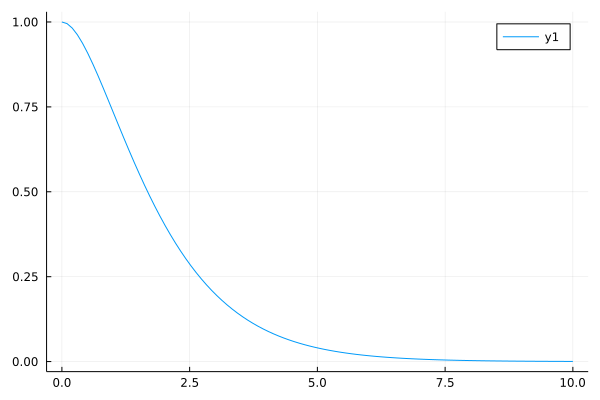

In [44]:
X = LinRange(0.0, 10., 100)
plot(X, pok1.(X))

    **pdt(rkcps::Real, wmus::Real)**

Given an activity rkcps (in kcps) and a dead time wmus (in mus), the average number
of events in that window is kcps/(1/wmus) = kcps * wmus.

In [45]:
function pdt(rkcps::Real, wmus::Real)
    λ = rkcps * wmus * 1e-3  # λ = rate/(1/w) = rate * w where rate in kcps, w in mus
    return pok1(λ)
end

pdt (generic function with 1 method)

#### NEC curve

In [46]:
function cnec(n_kcps::Real, 
    eff_gp::Real, 
    eff_sp::Real, 
    SOT::Real       =1.6, 
    eff_cwns::Real  = 1e-9,
    deadt_mus::Real = 0.6)

# n_kcps is the number of counts in kcps 
# eff_gp is the efficiency for good prompts
# eff_sp is the efficiency for single prompts
# SOT = S/T, the ratio of plots to trues 
# eff_cwns is the coincidence window in ns. Since rates come in kcps multiply by 10^3

eff_w =  eff_cwns *1e+3
nT = n_kcps * eff_gp               # number of good coincidences in scanner
nS = nT * SOT                      # number of scatters in scanner
n1 = n_kcps * eff_sp                # number of singles in scanner
nR = 2 * n1^2 * eff_w              # number of randoms
ntot = nT + nS + nR

prob = pdt(ntot, deadt_mus)
nT   *= prob
nS   *= prob
#nR   *= prob
ntot *= prob

nec = nT / (1.0 + nS/nT + nR/nT)   # nec


return nT, nS, nR, ntot, nec, prob
end

cnec (generic function with 4 methods)

- Given an activity rkcps (in kcps) and a dead time wmus (in mus), the average number
of events in that window is:

λ  = kcps * wmus, and the probability
for k=0,1 is pok1(λ)

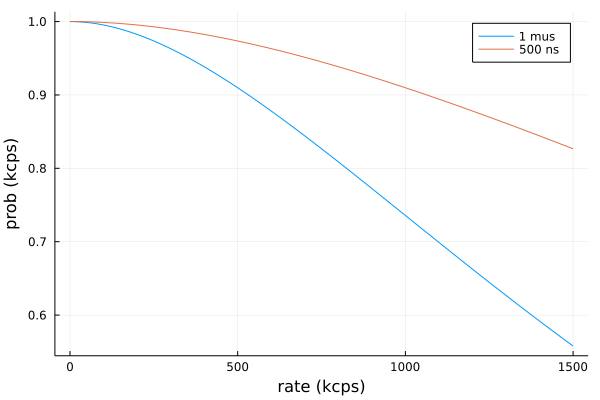

In [47]:
T = LinRange(0.0, 1500.0, 200)
p1 = plot(T, pdt.(T, (1.0,)), label="1 mus")
p2 = plot!(p1, T, pdt.(T, (0.5,)), label="500 ns")
xlabel!("rate (kcps)")
ylabel!("prob (kcps)")

In [48]:
function unzipn(rs)
    nT, nS, nR, ntot, nec, prob =  collect(zip(rs...))
    return collect(nT), collect(nS), collect(nR), collect(ntot),collect(nec), collect(prob)
end

unzipn (generic function with 1 method)

In [49]:
res = cnec.(NkBq, (rgp,), (rsp,), (sot,), (1e-9,), (0.5,))
nT, nS, nR, ntot, nec, prob = unzipn(res);

Integrated rates: trues = 33501.655596254655, scatters = 66255.85714260723, randoms = 320488.1145099603 NEC = 8684.400974286522


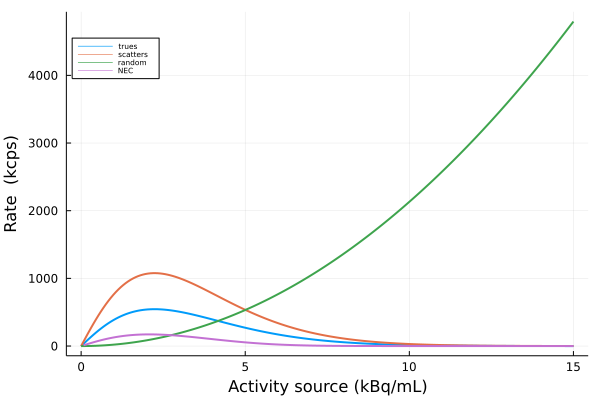

In [50]:
#p = scatter(AA,ntot, yerr = sqrt.(ntot), makersize=1, label="total", 
#legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
println("Integrated rates: trues = ", sum(nT), ", scatters = ", sum(nS), ", randoms = ", sum(nR), " NEC = ", sum(filter(!isnan, nec)))
p = plot(AA,nT,  lw=2, label="trues", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nS, lw=2, label="scatters", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nR, lw=2, label="random", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
p = plot!(p,AA,nec, lw=2, label="NEC", 
legend=(0.1,0.9), legendfontsize=5, fmt = :png,)
xlabel!("Activity source (kBq/mL)")
ylabel!("Rate  (kcps)")

In [51]:
png(p, "NECcurves_40mm")